In [1]:
#В этом файле изучается создание классификационной модели
# Подключим все необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Библиотеки из обучающего видео

import nltk #анализ текста
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
nltk.download('stopwords') #Загрузка стоп-слов

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
#Загрузим датасет с размеченными данными
#В датасете информация о негативных комментариях

data_path = '/content/drive/MyDrive/Colab Notebooks/MLdatasets/labeled.csv'

df = pd.read_csv(data_path)
df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [5]:
#Узнаем информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [6]:
df.describe()

,toxic
count,14412.000000
mean,0.334860
std,0.471958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
#Заменим float на int
df['toxic'] = df['toxic'].apply(int)

In [8]:
#Узнаем распредление комментариев
df['toxic'].value_counts()

,count
toxic,
0,9586
1,4826


In [9]:
#Возьму код из своей прошлой практики для разделения данных на тестовые и обучающие
train_df, test_df = train_test_split(df, test_size = 0.2)

In [10]:
test_df.shape #Посмотрим количество тестовых данных

(2883, 2)

In [11]:
test_df['toxic'].value_counts()# Соотношение комментариев

,count
toxic,
0,1943
1,940


##Обработка текста для дальнейшего обучения

In [12]:
sentence_example = df.iloc[1]["comment"] #Создаем пример комментария
tokens = word_tokenize(sentence_example, language="russian") #Делим комменты на токены
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation] #Удаляем знаки пунктуации
russian_stop_words = stopwords.words("russian") #И стоп-слова
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian") #И производим стемминг - удаляем окончания и переводим слова в нижний регистр
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

#Функция обработки

In [13]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [14]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

#Обучение модели

In [15]:
#TF-IDF - это технология, которая определяет "важность" слов в группе текстов, в нашем случае - комментариях
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))


In [16]:
#Делим все слова как признаки предложений
features = vectorizer.fit_transform(train_df["comment"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
#Обучаем модель определять по словам токсичность комментария
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

In [18]:
# Проверим первый коммент
model.predict(features[0])

array([0])

In [19]:
#Прочитаем его
train_df["comment"].iloc[0]

'Не придумала, как завуалировать намек на ошибку, поэтому только до мидий докопалась)\n'

# Создание пайплайна модели(делаем модель рабочей у пользователя)

In [20]:
#Мы объединяем векторайзер и модель, тем самым мы создаем модель, которая работает с цельными предложениями
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)
#Все из-за того, что мы до этого дробили предложения

In [21]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cb43f587a30>)),
                ('model', LogisticRegression(random_state=0))])

In [35]:
# Теперь протестируем модель

comment = input()
model_pipeline.predict([comment])

Классный день


array([0])

In [36]:
comment = input()
model_pipeline.predict([comment])

Тебе по голове постучать за такие слова


array([1])

#Измерим метрики модели

In [24]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8996913580246914

In [25]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6202127659574468

У нас слишком низкие показатели, мы можем поменять входной порог predict, так модель повысит точность, потому что требования будут меньше

In [26]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

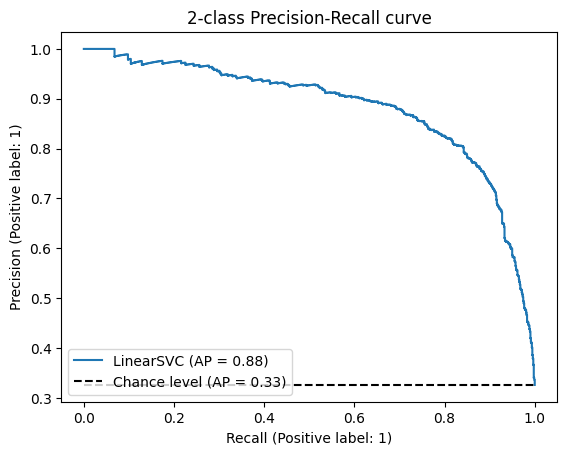

In [27]:
#Посмотрим график PrecisionRecall
display = PrecisionRecallDisplay.from_estimator(
    model_pipeline, X=test_df["comment"], y=test_df["toxic"], name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [28]:
np.where(prec > 0.95)# Узнаем, с какого комментария наша точность модели подходит под условие 0.95

(array([2570, 2571, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581,
        2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592,
        2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603,
        2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614,
        2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625,
        2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636,
        2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647,
        2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658,
        2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669,
        2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680,
        2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691,
        2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702,
        2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713,
        2714, 2715, 2716, 2717, 2718, 

In [31]:
thresholds[2570]#узнаем пороговое значение для точности в 0.95

0.7013005940483359

In [32]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[2570])#Проверяем пороговое значение на точность

0.9501661129568106

In [38]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[2570])

0.30425531914893617

In [39]:
#Создадим новый пайплайн для того, чтобы понять, какая модель нам подойдет
#Делается это с помощью GridSearch - библиотеки, которая использует на данных кросс-валидацию
#Кросс-валидация - это дележка данных на куски, которые затем проверяются как тестовые/обучающие данные
#Результат - лучшее разбиение данных
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),#векторайзер не поменялся
    ("model", #А модель поменялась
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]}, # стандартное значение единица, три коэффицента регуляризации
        cv=3,#Деление на три фолда,
         verbose=4 #Вывод всей информации об обучении
        )
    )
])


In [40]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.676 total time=   0.6s
[CV 2/3] END .............................C=0.1;, score=0.678 total time=   0.8s
[CV 3/3] END .............................C=0.1;, score=0.677 total time=   0.2s
[CV 1/3] END ...............................C=1;, score=0.825 total time=   0.5s
[CV 2/3] END ...............................C=1;, score=0.829 total time=   0.6s
[CV 3/3] END ...............................C=1;, score=0.824 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.867 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.865 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.854 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cb43baad6c0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [41]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [42]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cb43bb29ea0>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [43]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])


In [44]:
np.where(prec_c_10 > 0.95)

(array([2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492,
        2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503,
        2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514,
        2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525,
        2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536,
        2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547,
        2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558,
        2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569,
        2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580,
        2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591,
        2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602,
        2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613,
        2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624,
        2625, 2626, 2627, 2628, 2629, 

In [47]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[2482])


0.9511568123393316

In [48]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[2482])


0.39361702127659576

Мы подняли опредление негативных комментариев в тестовых данных на ~9% , что очень даже неплохо, значит наша модель улучшилась

**В итоге у нас получилась готовая модель классификации , которую можно задеплотить(внедрить) в рабочий продукт**